In [1]:
from glotaran_tools.specification_parser import parse_yml
from glotaran_core.model import Dataset
from glotaran_models.kinetic import KineticSeperableModel
import numpy as np
from lmfit import Parameters
# Imports for plotting

import matplotlib.pyplot as plt
%matplotlib notebook

fitspec = '''
type: kinetic

parameter: {}

compartments: [s1, s2, s3]

megacomplexes:
    - label: mc1
      k_matrices: [k1]

k_matrices:
  - label: "k1"
    matrix: {{
      '("s1","s1")': 1,
      '("s2","s2")': 2,
      '("s3","s3")': 3,
}}

initial_concentrations: []

irf: []

datasets: 
  - label: dataset1
    type: spectral
    megacomplexes: [mc1]
    path: 'data/dataset1.ascii'

'''
   

In [2]:
test_parameter = [101e-4, 202e-5, 505e-6]
test_amps = [50, 500, 5000]
test_x = np.arange(12820, 15120, 4.6)
times = np.asarray(np.arange(0, 1500, 1.5))
simparams = Parameters()
simparams.add("p1", 101e-3)
simparams.add("p2",202e-4)
simparams.add("p3",505e-5)

In [3]:
model = parse_yml(fitspec.format(test_parameter))

In [4]:
fitmodel = KineticSeperableModel(model)

[[  1.25880827e-023   3.44321818e-057   8.97359469e-023]
 [  1.69810958e-023   2.01525933e-056   1.31850804e-022]
 [  2.28903982e-023   1.16573948e-055   1.93478590e-022]
 ..., 
 [  2.68503369e+002   1.14939058e-305   1.28073799e-009]
 [  2.51389987e+002   1.95032874e-307   9.83121165e-010]
 [  2.35194804e+002   3.27078632e-309   7.53681052e-010]]
(1000, 501)


<IPython.core.display.Javascript object>


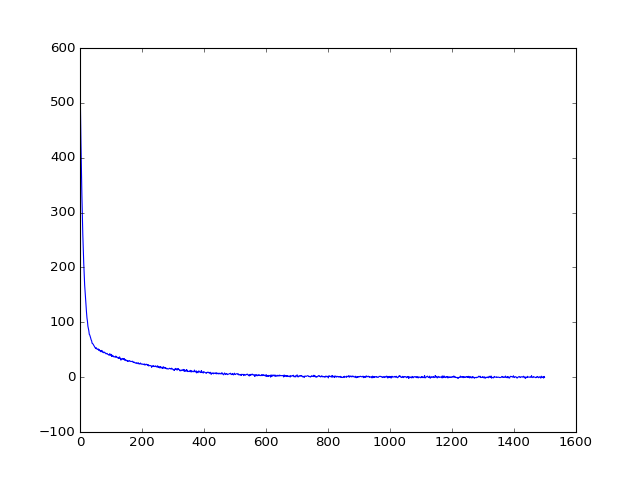

In [8]:
data = fitmodel.eval(simparams, *times, **{'dataset':'dataset1', 
                                           'noise':True, 'noise_std_dev':1,
                                           'x': test_x,
                                           'amplitudes':test_amps,
                                          'locations':[14700, 13515, 14180],
                                           'delta': [400,100,300]
                                           })
print(data.shape)
fig = plt.figure()
plt.plot(times, data[:, 300])

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.0197e+08                                    3.02e+11    
       1              2         2.4527e+07      3.77e+08       3.73e-03       2.40e+10    
       2              3         1.7454e+07      7.07e+06       1.82e-03       1.80e+10    
       3              5         1.4074e+07      3.38e+06       1.70e-03       1.40e+10    
       4              6         1.1832e+07      2.24e+06       3.40e-03       1.21e+10    
       5              7         8.8637e+06      2.97e+06       6.81e-03       1.01e+10    
       6              8         5.0503e+06      3.81e+06       1.36e-02       7.94e+09    
       7              9         1.4725e+06      3.58e+06       2.68e-02       1.97e+09    
       8             10         3.8013e+05      1.09e+06       2.80e-02       6.03e+08    
       9             11         3.0525e+05      7.49e+04       1.10e-02       2.81e+07    

<IPython.core.display.Javascript object>


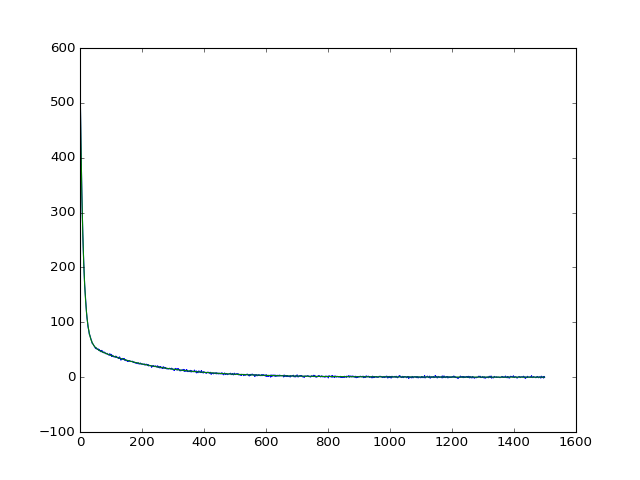

In [10]:
result = fitmodel.fit(fitmodel.get_initial_fitting_parameter(), 
                      *times, 
                      **{"data": data}
                     )
result.best_fit_parameter.pretty_print()
fitted_data = fitmodel.eval(result.best_fit_parameter, *times, **{'dataset':'dataset1','amplitudes':[50, 500, 5000]})
reconstructed_data = result.eval(*times, **{"data": data})
print('Fitted Amplitudes: {}'.format(result.e_matrix(*times, **{"data": data})))

fig = plt.figure()
plt.plot(times, data[:, 300])
# plt.plot(times, fitted_data[:, 0])
plt.plot(times, reconstructed_data[:, 300])